# Learning rate finder

Como hemos visto el learning rate es uno de los hiperparámetros que podemos cambiar durante el entrenamiento de una red neuronal, y de hecho, es uno de los más importantes. Por tanto debemos encotrar un valor bueno, pero buscarlo dando palos de ciego parece que no es la mejor idea. Lo mejor sería tener un algoritmo que nos ayude en esta tarea, y por suerte lo hay y lo vamos a explicar

Lo primero que se nos podría ocurrir es entrenar nuestro modelo con varios learning rates y quedarnos con el mejor resultado. Pero hay modeos muy grandes que tardan horas, días, incluso semanas en entrenarse, por lo que no parece la mejor idea

Así que una aproximación que podemos hacer es entrenar una época entera e ir cambiando el learning rate en cada mini batch. Haciendo esto el número de learning rates diferentes que vamos a probar es igual a la cantidad de mini batches que tenga nuestro data loader. Pero ahora hay que decidir cómo distribuir estos valores.

Supongamos que queremos probar valores de learning rate desde 10<sup>-8</sup> hasta 1, podemos distribuior los valores linealmente

![distribución lineal](./Imagenes/Distribucion_lineal.png)

Tenemos el problema que la mayoría de valores que se van a probar están por encima de 0,1, pero a lo mejor nuestro mejor valor de learning rate está por debajo de 0,1. Así que lo mejor es hacer una distribución logarítmica

![distribución logarítmica](./Imagenes/Distribucion_logaritmica.png)

Sabiéndo cómo hacer la distribución, ahora tenemos que calcular cómo cambiar el valor de learning rate en cada mini batch.

En cada mini batch, para cambiar el valor del learning rate podemos multiplicar por un número.

$$lr_i = q·lr_{i-1} = q^2·lr_{i-2} = ... = q^i·lr_0$$

Por tanto

$$lr_{N-1} = q^{N-1}·lr_0$$

Así que 

$$q^{N-1} = \frac{lr_{N-1}}{lr_0}$$

Así que se puede calcular $q$ como

$$q = \left(\frac{lr_{N-1}}{lr_0}\right)^{\frac{1}{N-1}}$$

Por último, no es necesario entrenar durante toda la epoch. Si el learning se dispara podemos para antes. Así que lo que vamos a hacer es que si el error durante el entrenamiento es mayor que 4 veces el menor error medido, podemos parar el entrenamiento.

Vamos a hacer esto en código. Vamos a verlo con el ejemplo que vimos de clasificación binaria con el dataset Cancer.

Descargamos los datos y creamos los dataframes

In [231]:
from sklearn import datasets
cancer = datasets.load_breast_cancer()

In [232]:
import pandas as pd

cancer_df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
cancer_df['type'] = cancer['target']
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Creamos el dataset y el dataloader

In [233]:
import torch

class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        cols = [col for col in dataframe.columns if col != 'target']
        self.parameters = torch.from_numpy(dataframe[cols].values).type(torch.float32)
        self.targets = torch.from_numpy(dataframe['type'].values).type(torch.float32)
        self.targets = self.targets.reshape((len(self.targets), 1))

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        parameters = self.parameters[idx]
        target = self.targets[idx]
        return parameters, target

ds = CancerDataset(cancer_df)

In [234]:
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds) - int(0.8*len(ds))], generator=torch.Generator().manual_seed(42))

In [235]:
from torch.utils.data import DataLoader

BS_train = 4 # Elegimos un batch size de 4 para tener varios valores de lr para probar
BS_val = 128

train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=BS_val, shuffle=False)

Creamos la red neuronal

In [236]:
from torch import nn

class CancerNeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_layers=[100, 50, 20]):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, hidden_layers[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[0], hidden_layers[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[1], hidden_layers[2]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[2], num_outputs),
        )
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        logits = self.network(x)
        probs = self.activation(logits)
        return logits, probs

model = CancerNeuralNetwork(num_inputs=31, num_outputs=1)

Se manda a la GPU

In [237]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model.to(device)

Using cuda device


CancerNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation): Sigmoid()
)

Definimos la función de pérdida

In [238]:
loss_fn = nn.BCEWithLogitsLoss()

Hacemos la función de búsqueda del learning rate

In [239]:
import math
import numpy as np

def lr_finder(model, train_dl, loss_fn, lr_init=1e-8, lr_end=10, increment=4):
    num = len(train_dl)-1 # Numero de lrs que vamos a probar
    q = (lr_end/lr_init)**(1/num) # Incremento de lr
    lr = lr_init
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = 0
    best_loss = 0
    losses = []
    lrs = []
    for batch, (X, y) in enumerate(train_dl):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        logits, probs = model(X)
        loss = loss_fn(logits, y)
        print(f"batch: {batch}, loss: {loss.item():.4f}, lr: {lr:.4e}, best_loss: {best_loss:.4f}", end='')
        if increment is not None:
            print(f", increment*best_loss: {increment*best_loss:.4f}")

            # Se para si el loss se dispara
            if batch > 1 and loss > increment * best_loss:
                print("Stopping")
                return lrs, losses
        else:
            print()
        
        # Se guarda la menor pérdida
        if loss < best_loss or batch==0:
            best_loss = loss
        
        # Se guardan los datos
        losses.append(loss.to("cpu").detach().numpy())
        lrs.append(math.log10(lr))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lr
        lr *= q

    return lrs, losses

In [240]:
[lrss, losses] = lr_finder(model, train_dl, loss_fn, increment=None)

batch: 0, loss: 6.8653, lr: 1.0000e-08, best_loss: 0.0000
batch: 1, loss: 3.1647, lr: 1.2013e-08, best_loss: 6.8653
batch: 2, loss: 8.8051, lr: 1.4431e-08, best_loss: 3.1647
batch: 3, loss: 5.6594, lr: 1.7336e-08, best_loss: 3.1647
batch: 4, loss: 9.1332, lr: 2.0825e-08, best_loss: 3.1647
batch: 5, loss: 2.8825, lr: 2.5017e-08, best_loss: 3.1647
batch: 6, loss: 5.0076, lr: 3.0052e-08, best_loss: 2.8825
batch: 7, loss: 7.6817, lr: 3.6101e-08, best_loss: 2.8825
batch: 8, loss: 1.8344, lr: 4.3368e-08, best_loss: 2.8825
batch: 9, loss: 2.7482, lr: 5.2097e-08, best_loss: 1.8344
batch: 10, loss: 4.9475, lr: 6.2584e-08, best_loss: 1.8344
batch: 11, loss: 2.4334, lr: 7.5181e-08, best_loss: 1.8344
batch: 12, loss: 0.0161, lr: 9.0313e-08, best_loss: 1.8344
batch: 13, loss: 5.8298, lr: 1.0849e-07, best_loss: 0.0161
batch: 14, loss: 7.3793, lr: 1.3033e-07, best_loss: 0.0161
batch: 15, loss: 4.2209, lr: 1.5656e-07, best_loss: 0.0161
batch: 16, loss: 8.3666, lr: 1.8808e-07, best_loss: 0.0161
batch: 

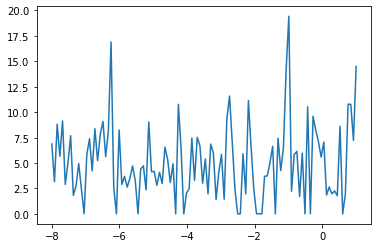

In [241]:
import matplotlib.pyplot as plt
plt.plot(lrss, losses)